In [2]:
!pip install lightning > /dev/null

# Classifying digits: Multi-class classification
---

We’ll build a model to classify digits into 10 mutually exclusive classes. Because we have many classes, this problem is an instance of multi-class classification.

The problem we’re trying to solve here is to classify grayscale images of handwritten digits (28 × 28 pixels) into their 10 categories (0 through 9). We’ll use the MNIST dataset. It’s a set of 60,000 training
images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s.

## Basic imports

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

import torchvision
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import ToTensor

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

## Load and visualize the data

In [4]:
train_dataset = CIFAR10(root="./cifar", train=True, transform=ToTensor(), download=True)
test_dataset = CIFAR10(root="./cifar", train=False, transform=ToTensor())

100%|██████████| 170498071/170498071 [00:12<00:00, 13223862.82it/s]


Extracting ./cifar/cifar-10-python.tar.gz to ./cifar


In [6]:
print(f'Training images: {len(train_dataset)}')
print(f'Testing images: {len(test_dataset)}')

Training images: 50000
Testing images: 10000


In [8]:
train_dataset, val_dataset = random_split(train_dataset, lengths=[45000, 5000])

### Datasets & DataLoaders

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: **torch.utils.data.DataLoader** and **torch.utils.data.Dataset** that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

In [9]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

Once we loaded the datasets, we can get a batch of images and display them. It is generally a good idea to visualize the images in order to see if additional preprocessing is needed.

tensor([5, 5, 0, 5, 0])
tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


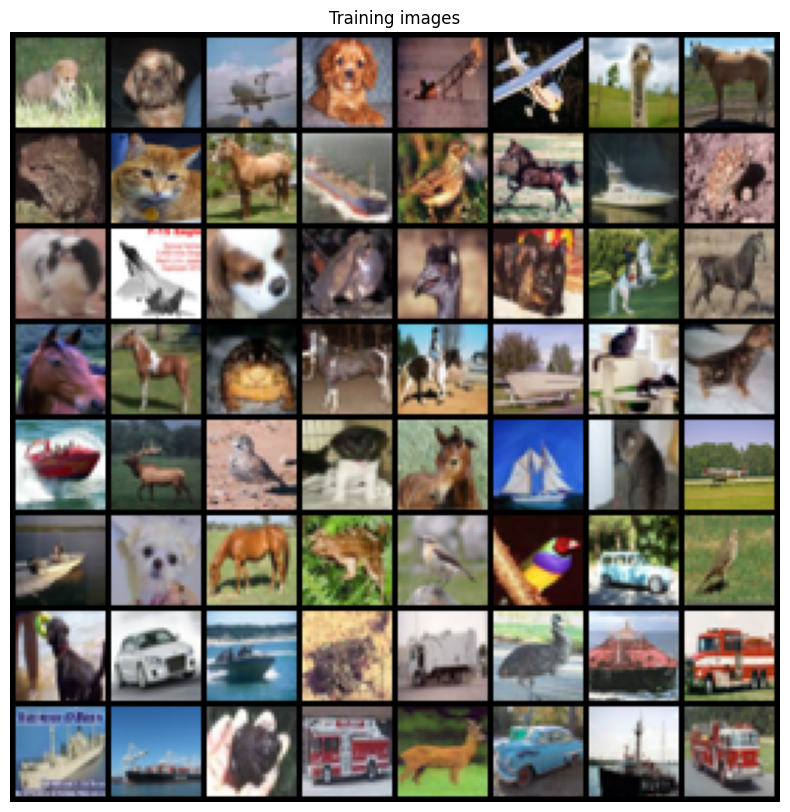

In [10]:
images, labels = next(iter(train_loader))


one_hot = torch.nn.functional.one_hot(labels)

print(labels[:5])
print(one_hot[:5])

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], padding=2,normalize=True), (1, 2, 0)))
plt.show()

## Training the model

The MNISTModel class is used as the basis for training. We need to give it a model to operate on the data.

In [11]:
class MNISTModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        """Initialize the MNISTModel class.

            Args:
                model (torch.nn.Module): The neural network model to be used for training and inference.
                learning_rate (float): The learning rate for the optimizer.
        """
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        # Initialize a dictionary to store the training history
        self.history = {
            'epochs': [],
            'loss': [],
            'val_loss': []
        }

    def forward(self, x):
        """Forward pass of the model.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)
            Returns:
                torch.Tensor: Output tensor after passing through the model
        """
        x = torch.flatten(x, start_dim=1)
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Perform a training step.

            Args:
                batch: A batch of training data containing features and labels.
                batch_idx (int): Index of the current batch in the epoch.
            Returns:
                torch.Tensor: Loss tensor to be optimized
        """
        features, true_labels = batch
        logits = self.forward(features)
        loss = F.cross_entropy(logits, true_labels)

        if(batch_idx==0):
            self.history['epochs'].append(self.current_epoch)
            self.history['loss'].append(loss)

        self.log("train_loss", loss)
        return loss  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        """Perform a validation step.

            Args:
                batch: A batch of validation data containing features and labels.
                batch_idx (int): Index of the current batch in the validation set.
            Returns:
                torch.Tensor: Validation loss tensor
        """
        features, true_labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, true_labels)

        if(batch_idx==0):
            self.history['val_loss'].append(loss)

        self.log("val_loss", loss, prog_bar=True)

        return loss

    def configure_optimizers(self):
        """Configure the optimizer for training.

            Returns:
                torch.optim.Optimizer: Optimizer for training
        """
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

The model is configured as follows:

In [13]:
# Define the number of input features (28x28 for MNIST images)
num_features = 28 * 28
# Define the number of output classes (10 for MNIST digits)
num_classes = 10

# Define the base model architecture using a sequential model
base_model = nn.Sequential(
    # First linear layer with ReLU activation
    nn.Linear(num_features, 64),
    nn.ReLU(),
    # Second linear layer with ReLU activation
    nn.Linear(64, 32),
    nn.ReLU(),
    # Final linear layer for outputting logits
    nn.Linear(32, num_classes)
)

There are two other things you should note about this architecture:

1. We end the model with a Dense layer of size 10. This means for each input
sample, the network will output a 10-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.

2. The last layer uses a softmax activation.It means the model will output a probability distribution over the 10 different output classes—for every input sample, the model will produce a 10-dimensional output vector, where output[i] is the probability that the sample belongs to class i. The 10 scores will sum to 1.

The **softmax** activation function transforms the raw outputs of the neural network into a vector of probabilities, essentially a probability distribution over the input classes.

\begin{align}
softmax(x_i) = \frac{e^{x_i}}{\sum^n_{j=1} e^{x_j}}
\end{align}

The best loss function to use in this case is categorical_crossentropy. It measures the distance between two probability distributions: here, between the probability distribution output by the model and the true distribution of the labels. By minimizing the distance between these two distributions, you train the model to output something as close as possible to the true labels. The function is defined as:

\begin{align}
CCE(y, \hat{y}) = -\sum_i y_i \cdot \ln(\hat{y}_i)
\end{align}

It is worth noting that Pytorch infers the activation function based on the loss. See [this link](https://discuss.pytorch.org/t/activation-function-for-last-layer/41151) for more details.

In [14]:
mnist_model = MNISTModel(model=base_model, learning_rate=0.05)

### [Callbacks](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html)

Callbacks allow you to add arbitrary self-contained programs to your training. At specific points during the flow of execution (hooks), the Callback interface allows you to design programs that encapsulate a full set of functionality. It de-couples functionality that does not need to be in the lightning module and can be shared across projects.

Lightning has a callback system to execute them when needed. Callbacks should capture NON-ESSENTIAL logic that is NOT required for your lightning module to run.

The **ModelCheckpoint** callback is used to save the model periodically by monitoring a quantity. In this case, the loss of the model.

### Training and validation

In [15]:
checkpoint_callback = ModelCheckpoint()

# The CSVLogger is used to log to local file system in yaml and CSV format.
trainer = L.Trainer(max_epochs=10,
                    logger=CSVLogger(save_dir="logs/", name="mnist-model"),
                    callbacks = [checkpoint_callback])

trainer.fit(
        model=mnist_model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
    )

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 52.6 K | train
---------------------------------------------
52.6 K    Trainable params
0         Non-trainable params
52.6 K    Total params
0.211     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [16]:
def compute_accuracy(model, dataloader, device=None):
    """Compute the accuracy of the model on the given dataloader.

        Args:
            model (torch.nn.Module): The model to evaluate.
            dataloader (torch.utils.data.DataLoader): The dataloader containing the data to evaluate.
            device (torch.device, optional): The device to use for computation. Defaults to None (uses CPU).

        Returns:
            float: The accuracy of the model on the given data.
    """
    if device is None:
        device = torch.device("cpu")
    model = model.eval()

    correct = 0.0
    total_examples = 0

    # Iterate over the data in the dataloader
    for idx, (features, labels) in enumerate(dataloader):

        features, labels = features.to(device), labels.to(device)

        # Forward pass of the model without gradient computation
        with torch.no_grad():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)

         # Compare the predicted labels with the true labels
        compare = labels == predictions
        # Accumulate the number of correct predictions
        correct += torch.sum(compare)
        # Accumulate the total number of examples
        total_examples += len(compare)

    return correct / total_examples

### Results and predictions

In [17]:
train_acc = compute_accuracy(mnist_model, train_loader)
val_acc = compute_accuracy(mnist_model, val_loader)
test_acc = compute_accuracy(mnist_model, test_loader)
print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

Train Acc 97.48% | Val Acc 95.96% | Test Acc 96.69%


Once we have a trained model, we can make some predictions on the test data.

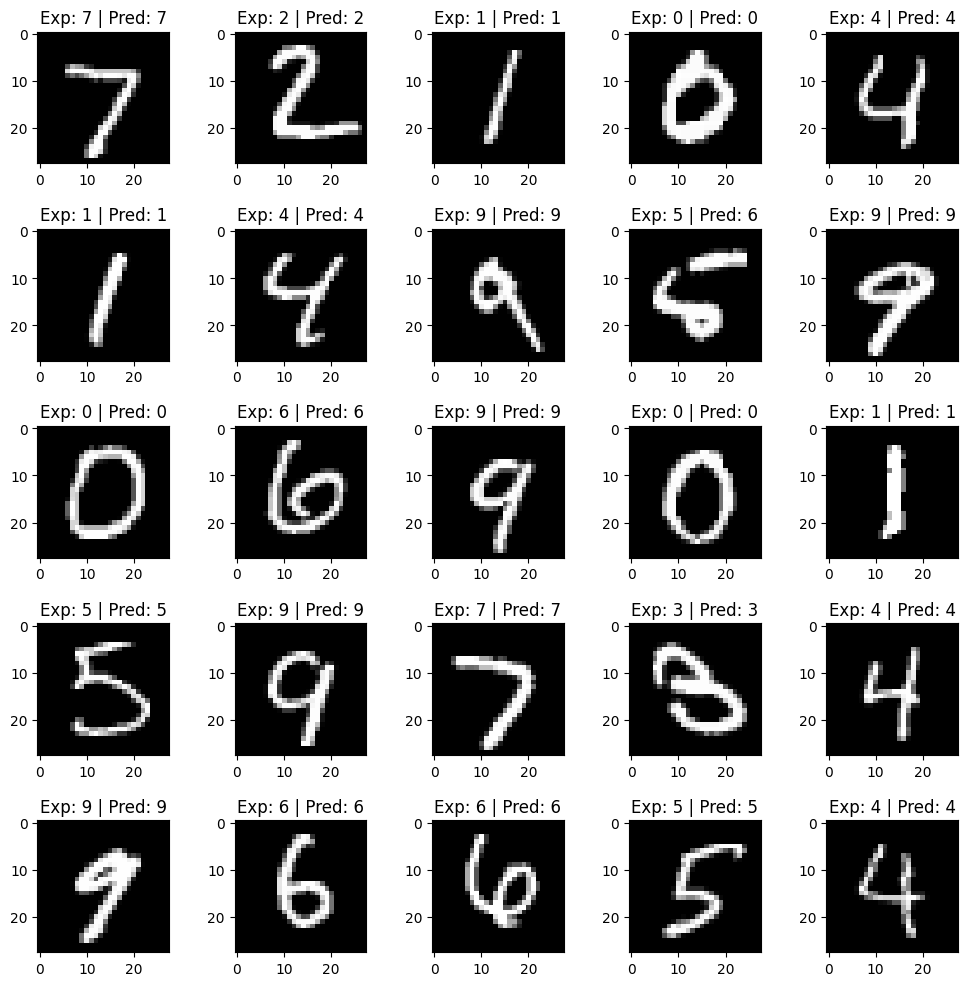

In [18]:
# Create a 5x5 subplot figure
f, ax = plt.subplots(5, 5, figsize=(10, 10))
# Adjust the layout of the subplots to avoid overlapping
f.tight_layout(pad=1.)

# Iterate over the first 25 test images
for idx in range(25):
    # Calculate the row and column index for the subplot
    row = idx // 5
    col = idx % 5

    # Get the test data and label for the current image
    test_data, test_label = test_dataset[idx]

    # Plot the test image using grayscale colormap
    ax[row, col].imshow(np.reshape(test_data, (28, 28, 1)), cmap='gray')

    # Forward pass of the model without gradient computation
    with torch.no_grad():
        # Get the model prediction for the test data
        prediction = mnist_model(test_data)

    # Set the title of the subplot with expected and predicted labels
    ax[row, col].set_title(f'Exp: {test_label} | Pred: {np.argmax(prediction)}')

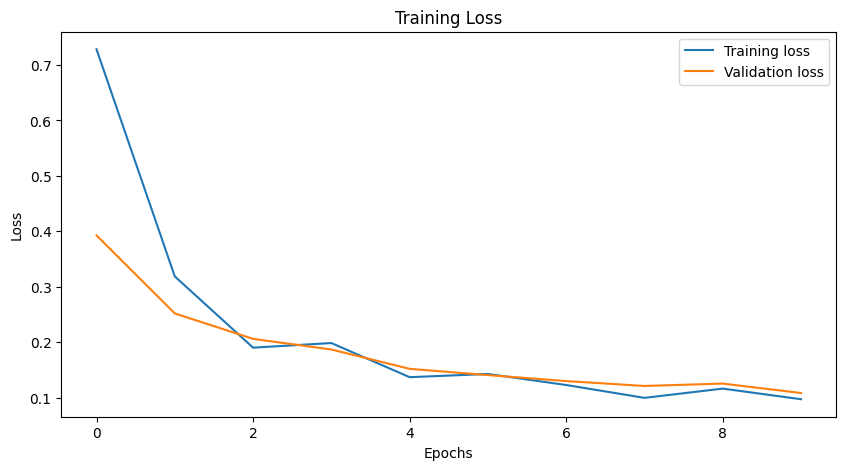

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
df_epochs = metrics.groupby('epoch').mean()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(df_epochs['train_loss'], label="Training loss")
ax.plot(df_epochs['val_loss'], label="Validation loss")
ax.set_title("Training Loss")
ax.legend(loc='upper right')

## Convolutional neural networks
---

![Conv net](https://miro.medium.com/max/1200/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

The fundamental difference between a densely connected layer and a convolution
layer is this: Dense layers learn global patterns in their input feature space (for example, for a MNIST digit, patterns involving all pixels), whereas convolution layers learn local patterns—in the case of images, patterns found in small 2D windows of the inputs.

![local features](https://media.geeksforgeeks.org/wp-content/uploads/20211129095034/Importantfeaturesoftheimage.png)

This key characteristic gives convnets two interesting properties:

- The patterns they learn are **translation-invariant**. After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. A densely connected model would have to learn the pattern anew if it appeared at a new location. This makes convnets data-efficient when processing images (because the visual world is fundamentally translation-invariant): they need fewer training samples to learn representations that have generalization power.
- They can learn **spatial hierarchies of patterns**. A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts, because the visual world is fundamentally spatially hierarchical.

![Spatial hierarchies](https://i.sstatic.net/bN2iA.png)

## Convolution basics

Convolutions operate over tensors called feature maps, with two spatial axes (height and width) as well as a depth axis (also called the channels axis). For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray).

Since convolutional layers can recieve matrices as input, we can leave the input images' shape as is, and just perform normalization of its values.

The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an output feature map. This output feature map is still tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for filters. Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,” for instance.

Convolutions are defined by two key parameters:

- Size of the patches extracted from the inputs: These are typically 3 × 3 or 5 × 5.
- Depth of the output feature map: This is the number of filters computed by the convolution.

In Keras Conv2D layers, these parameters are the first arguments passed to the layer:

Conv2D(output_depth, (window_height, window_width)).

A convolution works by sliding these windows of size 3 × 3 or 5 × 5 over the
input feature map, stopping at every possible location, and extracting the patch of surrounding features.

![Strides](https://d2l.ai/_images/conv-pad.svg)

### Padding

Padding consists of adding an appropriate number of rows and columns on each side of the input feature map so as to make it possible to fit center convolution windows around every input tile. In Conv2D layers, padding is configurable via the padding argument, which takes two values: "valid", which means no padding (only valid window locations will be used), and "same", which means "pad in such a way as to have an output with the same width and height as the input.” The padding argument defaults to "valid".

![Padding](https://programmathically.com/wp-content/uploads/2021/12/Screenshot-2021-12-03-at-10.33.11-1024x774.png)

### Strides

The other factor that can influence output size is the notion of strides. Our description of convolution so far has assumed that the center tiles of the convolution windows are all contiguous. But the distance between two successive windows is a parameter of the convolution, called its stride, which defaults to 1. It’s possible to have strided convolutions: convolutions with a stride higher than 1. Using stride 2 means the width and height of the feature map are downsampled by a factor of 2 (in addition to any changes induced by border effects). Strided convolutions are rarely used in classification models.

### Max-pooling

Max pooling consists of extracting windows from the input feature maps and
outputting the max value of each channel. It’s conceptually similar to convolution, except that instead of transforming local patches via a learned linear transformation (the convolution kernel), they’re transformed via a hardcoded max tensor operation. A big difference from convolution is that max pooling is usually done with 2 × 2 windows and stride 2, in order to downsample the feature maps by a factor of 2.

## Putting it all together



### Model definition

In [23]:
class MnistCnnModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        """Initialize the MnistCnnModel class.

            Args:
                model (torch.nn.Module): The CNN model to be used for training and inference.
                learning_rate (float): The learning rate for the optimizer.
        """
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

    def forward(self, x):
        """Forward pass of the model.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)

            Returns:
                torch.Tensor: Output tensor after passing through the model
        """
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Perform a training step.

            Args:
                batch: A batch of training data containing features and labels.
                batch_idx (int): Index of the current batch in the epoch.

            Returns:
                torch.Tensor: Loss tensor to be optimized
        """
        features, true_labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, true_labels)
        self.log("train_loss", loss)
        return loss  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        """Perform a validation step.

            Args:
                batch: A batch of validation data containing features and labels.
                batch_idx (int): Index of the current batch in the validation set.

            Returns:
                torch.Tensor: Validation loss tensor
        """
        features, true_labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, true_labels)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        """Configure the optimizer for training.

            Returns:
                torch.optim.Optimizer: Optimizer for training
        """
        optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        return optimizer

In [27]:
class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        """Initialize the PyTorchCNN class.

        Args:
            num_classes (int): The number of output classes for the model.
        """
        super().__init__()

        # Define the CNN layers
        self.cnn_layers = torch.nn.Sequential(

            # First convolutional layer with batch normalization and ReLU activation
            torch.nn.Conv2d(1, 32, kernel_size=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),

            torch.nn.MaxPool2d(kernel_size=2),

            # Second convolutional layer with batch normalization and ReLU activation
            torch.nn.Conv2d(32, 64, kernel_size=3),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            # Third convolutional layer with batch normalization and ReLU activation
            torch.nn.Conv2d(64, 128, kernel_size=3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )

        # Define the fully connected layers
        self.fc_layers = torch.nn.Sequential(

            # Hidden fully connected layer with batch normalization and ReLU activation
            torch.nn.Linear(128, 16),
            torch.nn.BatchNorm1d(16),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(16, num_classes)
        )

    def forward(self, x):
        """Forward pass of the model.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)

            Returns:
                torch.Tensor: Output logits tensor of shape (batch_size, num_classes)
        """
        # Forward pass through the CNN layers
        x = self.cnn_layers(x)
        # print(x.shape)
        # Flatten the output of CNN layers to prepare for fully connected layers
        x = torch.flatten(x, start_dim=1)
        # print(x.shape)
        # Forward pass through the fully connected layers to get the logits
        logits = self.fc_layers(x)
        # print(logits.shape)
        return logits

### Training the CNN

In [37]:
pytorch_cnn_model = PyTorchCNN(num_classes=10)
mnist_cnn_model = MnistCnnModel(model=pytorch_cnn_model, learning_rate=0.1)

trainer_cnn = L.Trainer(
    max_epochs=15,
    logger=CSVLogger(save_dir="logs/", name="mnist-cnn-model"),
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [38]:
trainer_cnn.fit(
        model=mnist_cnn_model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
    )

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | PyTorchCNN | 95.4 K | train
---------------------------------------------
95.4 K    Trainable params
0         Non-trainable params
95.4 K    Total params
0.382     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | PyTorchCNN | 95.4 K | train
---------------------------------------------
95.4 K    Trainable params
0         Non-trainable params
95.4 K    Total params
0.382     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


### Results and predictions

In [32]:
train_acc = compute_accuracy(mnist_cnn_model, train_loader)
val_acc = compute_accuracy(mnist_cnn_model, val_loader)
test_acc = compute_accuracy(mnist_cnn_model, test_loader)
print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

Train Acc 80.82% | Val Acc 80.38% | Test Acc 79.55%


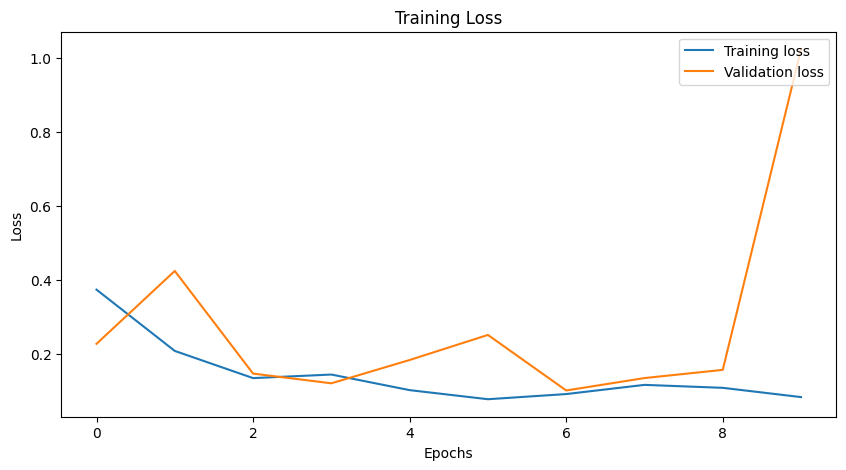

In [33]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer_cnn.logger.log_dir}/metrics.csv")
# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
# Plot the training loss over epochs
ax.plot(df_epochs['train_loss'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_loss'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

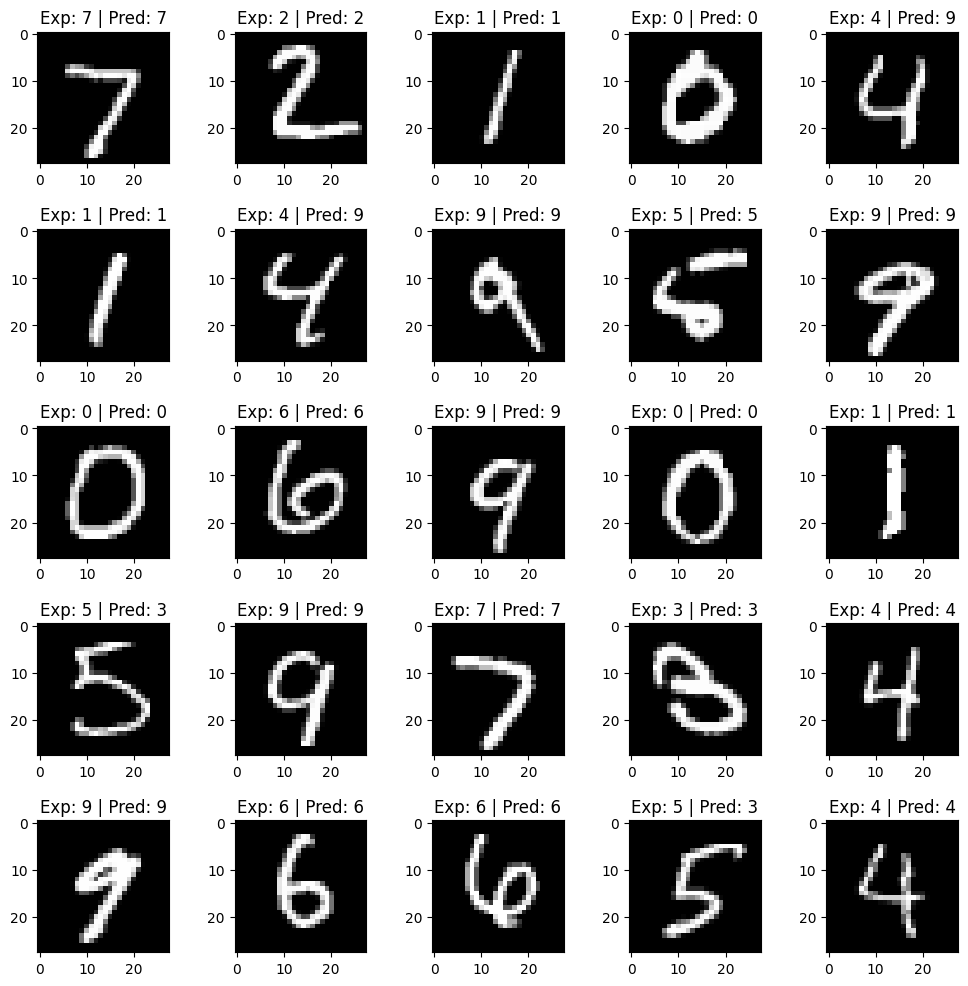

In [34]:
# Create a 5x5 subplot figure
f, ax = plt.subplots(5, 5, figsize=(10, 10))
# Adjust the layout of the subplots to avoid overlapping
f.tight_layout(pad=1.)

# Iterate over the first 25 test images
for idx in range(25):
    # Calculate the row and column index for the subplot
    row = idx // 5
    col = idx % 5

    # Get the test data and label for the current image
    test_data, test_label = test_dataset[idx]

    # Plot the test image using grayscale colormap
    ax[row, col].imshow(np.reshape(test_data, (28, 28, 1)), cmap='gray')

    # Reshape the test data to match the model input shape
    test_data = np.reshape(test_data, (1, 1, 28, 28))

    # Forward pass of the model without gradient computation
    with torch.no_grad():
        # Get the model prediction for the test data
        prediction = mnist_cnn_model(test_data)

    # Set the title of the subplot with expected and predicted labels
    ax[row, col].set_title(f'Exp: {test_label} | Pred: {np.argmax(prediction)}')

# Challenge

Make the necesary changes to train the model with the [Cifar10 Dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10).

Make sure to visualize the dataset, and a batch of predictions.